# How to split shapes with plotly

## The Task: Remove the westernmost islands from the Alaska shape so that it doesn't force a full-world map perspective

## Import Necessary Packages

In [1]:
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt

## Load US Shapefile

In [3]:
states_gdf = gpd.read_file('./data/cb_2018_us_state_5m.shp')

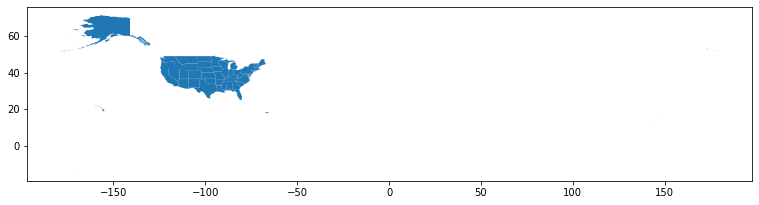

In [4]:
fig, ax = plt.subplots(figsize=(13,8))
states_gdf.plot(ax=ax)

In [5]:
states_gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,31,01779792,0400000US31,31,NE,Nebraska,00,198956658395,1371829134,"POLYGON ((-104.05351 41.15726, -104.05267 41.2..."
1,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-122.32834 48.02134, -122.3217..."
2,35,00897535,0400000US35,35,NM,New Mexico,00,314196306401,728776523,"POLYGON ((-109.05017 31.48000, -109.04984 31.4..."
3,46,01785534,0400000US46,46,SD,South Dakota,00,196346981786,3382720225,"POLYGON ((-104.05770 44.99743, -104.05021 44.9..."
4,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"POLYGON ((-106.64548 31.89867, -106.64084 31.9..."


## Grab Alaska shape

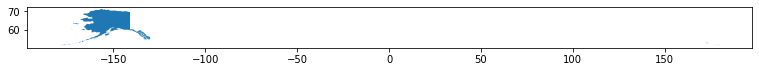

In [6]:
alaska_gdf = states_gdf.loc[states_gdf['STUSPS'] == "AK"]

# plot the alaska GeoDataFrame
fig, ax = plt.subplots(figsize=(13,8))
alaska_gdf.plot(ax=ax)

In [7]:
alaska_gdf['geometry']

55    MULTIPOLYGON (((179.48246 51.98283, 179.48656 ...
Name: geometry, dtype: geometry

In [9]:
alaska_gdf['geometry'].values

<GeometryArray>
Length: 1, dtype: geometry

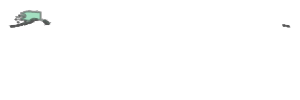

In [13]:
alaska_gdf['geometry'].values[0]

Now we've gotten to the Shapely MultiPolygon

In [14]:
alaska_mp = alaska_gdf['geometry'].values[0]

To get a single polygon:

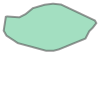

In [25]:
alaska_mp[0]

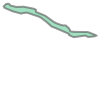

In [26]:
alaska_mp[1]

Number of polygons in Alaska's shape:

In [27]:
len(alaska_mp)

142

In [55]:
# convert these polygons into GeoDataFrame
al_exp_gdf = gpd.GeoDataFrame(alaska_mp)

In [56]:
al_exp_gdf

,0
0,"POLYGON ((179.482464 51.982834, 179.486565 51...."
1,"POLYGON ((178.625536 51.637303, 178.645511 51...."
2,"POLYGON ((178.446964 51.978222, 178.463385 51...."
3,"POLYGON ((178.236931 51.828209, 178.305568 51...."
4,"POLYGON ((178.09461 52.033294, 178.107266 52.0..."
...,...
137,"POLYGON ((-178.681285 51.608951, -178.638455 5..."
138,"POLYGON ((-178.857365 51.57659, -178.828811 51..."
139,"POLYGON ((-178.870118 51.795261, -178.858248 5..."
140,"POLYGON ((-178.992094 51.381311, -178.977782 5..."


In [57]:
# set geometry column
al_exp_gdf.columns = ['geometry']

finding alaska polygons that are on the contiguous states' side of the international date line

In [102]:
from shapely.geometry import Polygon

# create polygon that covers area we do want
target_area_polygon = Polygon([(-180, 50), (-180, 75), (-100, 75), (-100, 50)])

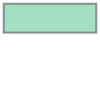

In [103]:
target_area_polygon

In [104]:
al_exp_gdf.intersects(target_area_polygon)

0      False
1      False
2      False
3      False
4      False
       ...  
137     True
138     True
139     True
140     True
141     True
Length: 142, dtype: bool

In [105]:
target_shapes = al_exp_gdf.loc[al_exp_gdf.intersects(target_area_polygon)]

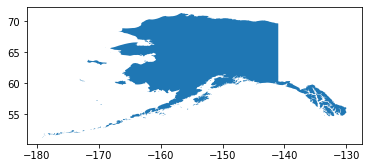

In [106]:
target_shapes.plot()

## Combining these shapes back into a single Alaska row

In [107]:
alaska_gdf

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
55,02,01785533,0400000US02,02,AK,Alaska,00,1478839695958,245481577452,"MULTIPOLYGON (((179.48246 51.98283, 179.48656 ..."


In [108]:
# add a column to groupby

target_shapes['STUSPS'] = 'AK'
target_shapes

//anaconda3/envs/geo-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,geometry,STUSPS
12,"POLYGON ((-131.24119 55.09255, -131.20728 55.1...",AK
13,"POLYGON ((-131.48662 54.95039, -131.48268 54.9...",AK
14,"POLYGON ((-131.62195 54.94653, -131.58487 54.9...",AK
15,"POLYGON ((-131.64628 55.03558, -131.62074 55.0...",AK
16,"POLYGON ((-131.87057 55.36455, -131.85430 55.4...",AK
...,...,...
137,"POLYGON ((-178.68129 51.60895, -178.63845 51.6...",AK
138,"POLYGON ((-178.85737 51.57659, -178.82881 51.5...",AK
139,"POLYGON ((-178.87012 51.79526, -178.85825 51.8...",AK
140,"POLYGON ((-178.99209 51.38131, -178.97778 51.3...",AK


In [109]:
alaska_trimmed = target_shapes.dissolve(by='STUSPS')
alaska_trimmed

,geometry
STUSPS,
AK,"MULTIPOLYGON (((-179.13724 51.28601, -179.1135..."


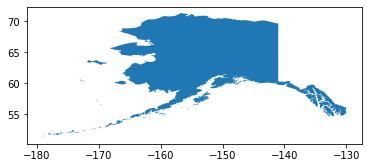

In [110]:
alaska_trimmed.plot()

In [111]:
states_trimmed = states_gdf.copy()
states_trimmed.loc[states_trimmed['STUSPS'] == 'AK', 'geometry'] = alaska_trimmed['geometry'].values

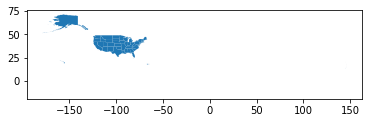

In [112]:
states_trimmed.plot()

## Trimming Alaska alone didn't solve my want to zoom in on the 50 States. I'll remove Guam, the Commonwealth of the Northern Mariana Islands, and American Samoa.

In [113]:
states_trimmed = states_trimmed.loc[states_trimmed['STUSPS'].isin(['GU', 'MP', 'AS']) == False]

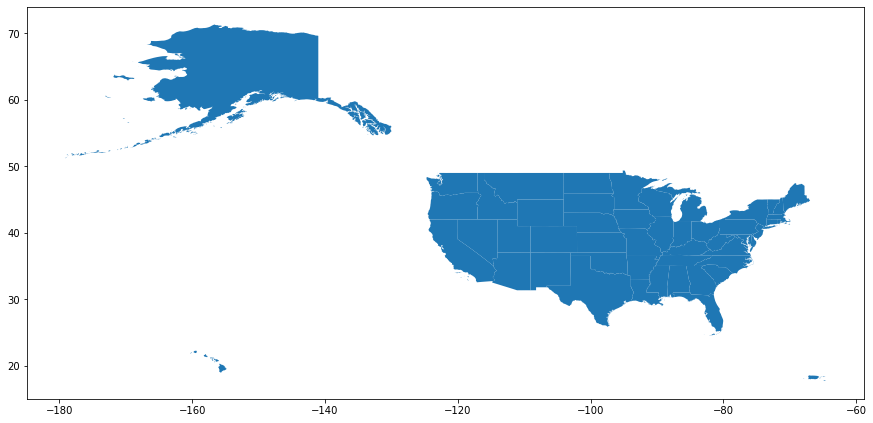

In [114]:
fig, ax = plt.subplots(figsize=(15, 9))
states_trimmed.plot(ax=ax)

## Let's try another way to adjust Alaska without cutting off the western islands

In [115]:
# first I thought to shift with .translate(). Unfortunately this didn't
# compensate for the circular globe. 
# latitute 170 became 200 instead of -120

alaska_shifted = alaska_gdf.translate(xoff=30)

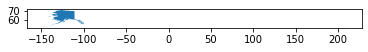

In [116]:
alaska_shifted.plot()

In [117]:
western_shapes = al_exp_gdf.loc[al_exp_gdf.intersects(target_area_polygon) == False]

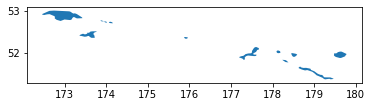

In [118]:
western_shapes.plot()

In [120]:
western_shapes_shifted = western_shapes.translate(xoff=-360)

(-190, -120.0)

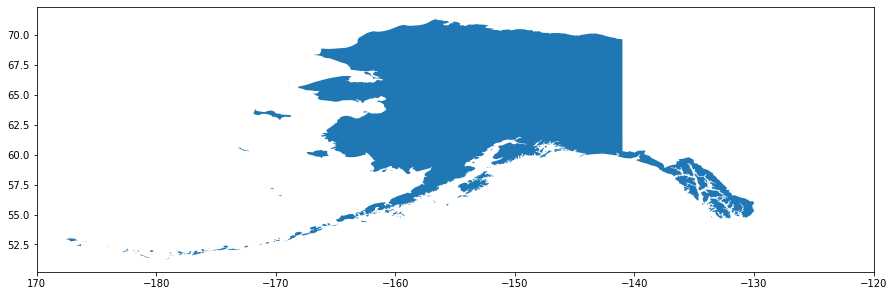

In [129]:
fig, ax = plt.subplots(figsize=(15, 12))
western_shapes_shifted.plot(ax=ax)
alaska_trimmed.plot(ax=ax)

locs, labels = plt.xticks()
labels[1] = '170'
plt.xticks(locs, labels)
plt.xlim(-190)

### Use append to combine alaska shapes into a single dataframe for "dissolving"

In [134]:
west_al_shift_gdf = gpd.GeoDataFrame(western_shapes_shifted)
west_al_shift_gdf.columns = ['geometry']
west_al_shift_gdf['STUSPS'] = 'AK'

al_shifted_actual_gdf = west_al_shift_gdf.append(target_shapes, ignore_index=True)

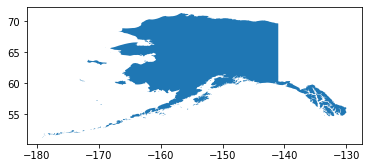

In [135]:
alaska_shapes.plot()

In [132]:
western_shapes_shifted.shape

(12,)

In [133]:
alaska_trimmed.shape

(1, 1)

In [140]:
western_shapes_shifted

0     POLYGON ((-180.518 51.983, -180.513 51.984, -1...
1     POLYGON ((-181.374 51.637, -181.354 51.658, -1...
2     POLYGON ((-181.553 51.978, -181.537 51.988, -1...
3     POLYGON ((-181.763 51.828, -181.694 51.822, -1...
4     POLYGON ((-181.905 52.033, -181.893 52.046, -1...
5     POLYGON ((-182.797 51.897, -182.766 51.910, -1...
6     POLYGON ((-184.126 52.371, -184.093 52.376, -1...
7     POLYGON ((-185.931 52.735, -185.908 52.742, -1...
8     POLYGON ((-186.046 52.751, -186.017 52.749, -1...
9     POLYGON ((-186.133 52.775, -186.119 52.775, -1...
10    POLYGON ((-186.644 52.406, -186.620 52.432, -1...
11    POLYGON ((-187.538 52.927, -187.371 53.001, -1...
dtype: geometry

In [139]:
target_shapes

,geometry,STUSPS
12,"POLYGON ((-131.24119 55.09255, -131.20728 55.1...",AK
13,"POLYGON ((-131.48662 54.95039, -131.48268 54.9...",AK
14,"POLYGON ((-131.62195 54.94653, -131.58487 54.9...",AK
15,"POLYGON ((-131.64628 55.03558, -131.62074 55.0...",AK
16,"POLYGON ((-131.87057 55.36455, -131.85430 55.4...",AK
...,...,...
137,"POLYGON ((-178.68129 51.60895, -178.63845 51.6...",AK
138,"POLYGON ((-178.85737 51.57659, -178.82881 51.5...",AK
139,"POLYGON ((-178.87012 51.79526, -178.85825 51.8...",AK
140,"POLYGON ((-178.99209 51.38131, -178.97778 51.3...",AK


## Testing Folium with shapes that cross the 